In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sbn # For nice looking plots.

import numpy as np
import scipy as sp
import scipy.io

import os
import copy
import time
import datetime

import tensorflow as tf

import sklearn
import sklearn.ensemble
import sklearn.preprocessing
import sklearn.svm

np.set_printoptions(precision=2, suppress=True, linewidth=140)

/usr/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
# Load the training and test data
sarcos_inv = scipy.io.loadmat('../data/sarcos_inv.mat')['sarcos_inv']
sarcos_inv_test = scipy.io.loadmat('../data/sarcos_inv_test.mat')['sarcos_inv_test']

scaler_x = None
scaler_y = None

def split_data(data, timesteps=1, train_scaler=False):
    global scaler_x, scaler_y
    
    X, Y = np.split(data, [21], axis=1)
    
    if timesteps == 1:
        Xres, Yres = X, Y
    else:
        Xres = np.zeros((X.shape[0] - timesteps + 1, 21 * timesteps))
        Yres = Y[timesteps - 1:]
    
    for i in xrange(X.shape[0] - timesteps + 1):
        Xres[i] = np.reshape(X[i:i+timesteps], -1)
        
    if train_scaler:
        scaler_x = sklearn.preprocessing.StandardScaler()
        scaler_y = sklearn.preprocessing.StandardScaler()
        scaler_x.fit(Xres)
        scaler_y.fit(Yres)
    
    if scaler_x is not None:
        return scaler_x.transform(Xres), scaler_y.transform(Yres)
    
    return Xres, Yres


In [11]:
class MultidimSVR(object):
    def __init__(self, param):
        self.param = param
        
    def fit(self, X, Y):
        self.models = []
        for yi in xrange(Y.shape[1]):
            model = sklearn.svm.SVR(**self.param)
            model.fit(X, Y[:, yi])
            self.models.append(model)
            
    def predict(self, X):
        res = []
        for model in self.models:
            res.append(model.predict(X))
            
        return np.column_stack(res)

# Train support vector regression with different tree depth and n_estimators

In [25]:
import  sklearn.model_selection 

# Training with different tree depth
total_params = []

for history_steps in [1, 3]:
    params = []
    for C in [0.1, 1.0, 10., 20, 50.]:
        for epsilon in [1e-4, 0.001, 0.01, 0.1, 1.0]:
            params.append({
                'model': {
                    'C': C,
                    'epsilon': epsilon,
                    'verbose': True                    
                },
                'history_steps': history_steps
            })

    X, Y = split_data(sarcos_inv, train_scaler=True, timesteps=history_steps)

    pert = np.random.permutation(X.shape[0])
    X = X[pert[::10]]
    Y = Y[pert[::10]]
    
    # Create a k-fold object
    nfold = 2
    kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)

    # Model orders to be tested
    nd = len(params)

    RSSts = np.zeros((len(params), nfold))

    for isplit, Ind in enumerate(kf.split(X)):
        print('kfold split: %d' % (isplit))

        Itr, Its = Ind
        xtr = X[Itr]
        ytr = Y[Itr]
        xts = X[Its]
        yts = Y[Its]

        for it, param in enumerate(params):
            model = MultidimSVR(param['model'])
            model.fit(xtr[:], ytr)

            yhat = model.predict(xts)

            RSSts[it, isplit] = np.mean(
                (scaler_y.inverse_transform(yts) - scaler_y.inverse_transform(yhat))**2)

    for i, p in enumerate(params):
        p['l2_mean'] = np.mean(RSSts, axis=1)[i]
        p['l2_std'] = np.std(RSSts, axis=1)[i] / np.sqrt(nfold - 1)


# for param in params:
#     print 'Training for:', param
#     now = time.time()

#     Ypred = np.zeros_like(Yts)
    
#     # Need to fit a model for each output dimension.
#     for yi in xrange(Y.shape[1]):
#         model = sklearn.svm.SVR(**param)    
#         model.fit(X[pert[::5]], Y[pert[::5]][:, yi])
    
#         Ypred[:, yi] = model.predict(Xts)


#     param['l2_loss'] = sklearn.metrics.mean_squared_error(
#         scaler_y.inverse_transform(Yts), 
#         scaler_y.inverse_transform(Ypred))
    
#     print 'Took %0.2f sec, l2_loss=%0.3f' % (time.time() - now, param['l2_loss'])
    
# print 'done'

kfold split: 0
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][

KeyboardInterrupt: 

In [ ]:
np.savez_compressed('svr_kfold_result.npz', params=params)

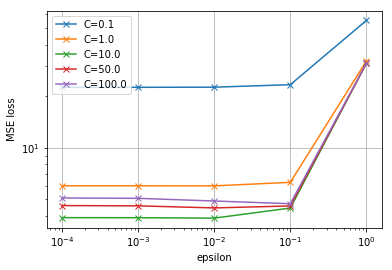

In [9]:
for C in np.unique([p['C'] for p in params]):
    pars = [p for p in params if p['C'] == C]
    x = [p['epsilon'] for p in pars]
    y = [p['l2_loss'] for p in pars]

    plt.loglog(x, y, 'x-', label="C=%0.1f" % (C))
    
plt.xlabel('epsilon')
plt.ylabel('MSE loss')
plt.grid()
plt.legend()